In [148]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as patches
import matplotlib.pylab as pylab
import matplotlib.ticker as mtick
from scipy.ndimage.filters import gaussian_filter1d

import csv
import numpy as np

params = {'axes.titlesize': 19,      
         'axes.labelsize': 17,
         'font.size': 13}
pylab.rcParams.update(params)

In [149]:
option_list = ['kaggle', 'chest', 'mnist-relu', 'mnist-sigmoid', 'cifar-10-relu', 'cifar-10-sigmoid', 'cifar-10-top3-relu', 'cifar-10-top3-sigmoid'] 

epsilon_list = [['0.5'], ['0.5'], ['0.01', '0.05'],
['0.01', '0.05'], ['0.01', '0.05'], ['0.01', '0.05']]

model_list = ['model #1 (Credit Card Fraud)',
              'model #2 (Chest X-ray)',
              'model #3 (MNIST ReLU)',
              'model #4 (MNIST Sigmoid)',
              'model #5 (CIFAR-10 ReLU)',
              'model #6 (CIFAR-10 Sigmoid)']

# color_scheme = ['b', 'c', 'g', 'm', 'maroon', 'darkgoldenrod']
color_scheme = ['black'] * 6

line_style_scheme = ['-', '--', '-.', ':']

use_highest_rather_than_median = True

In [150]:
def read_robustness_from_baseline(baselinefile, epsilon_index):
    # Read from baseline log
    robustness_baseline_lst = []
    num_epoch = 0
    with open(baselinefile, newline='') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',', quotechar='"')
        # This skips the first 2 rows of the CSV file (the first pruning starts at row 3).
        next(csvreader)
       
        for row in csvreader:
            num_epoch += 1
            # The first 1 or 2 items in each row are number of robustness instances, depends on epsilon index
            # The last item in each row is the [loss, accuracy]
            robustness_baseline_lst.append(int(row[epsilon_index]))
            # print(robustness[-1],accuracy[-1])
        num_epoch_baseline = num_epoch
    
    return robustness_baseline_lst

def read_accuracy_from_baseline(baselinefile):
    # Read from baseline log
    accuracy_baseline_lst = []
    num_epoch = 0
    with open(baselinefile, newline='') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',', quotechar='"')
        # This skips the first 2 rows of the CSV file (the first pruning starts at row 3).
        next(csvreader)
       
        for row in csvreader:
            num_epoch += 1
            accuracy_baseline_lst.append(float(row[-1][1:-1].split(',')[-1]))
            # print(robustness[-1],accuracy[-1])
        num_epoch_baseline = num_epoch
    
    return accuracy_baseline_lst


In [151]:
def read_robustness_from_our_stat(robustness_stat_file, num_epoch_baseline, highest=use_highest_rather_than_median):
    robustness_our_lst = []
    if highest:
        index_of_choice = 2
    else:
        index_of_choice = 3

    num_epoch = 0
    with open(robustness_stat_file, newline='') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',', quotechar='"')
        next(csvreader)
       
        for row in csvreader:
            robustness_our_lst.append(int(row[index_of_choice]))
            num_epoch += 1
            if num_epoch >= num_epoch_baseline:
                break
    return robustness_our_lst

def read_accuracy_from_our_stat(accuracy_stat_file, num_epoch_baseline, highest=use_highest_rather_than_median):
    accuracy_our_lst = []
    if highest:
        index_of_choice = 2
    else:
        index_of_choice = 3

    num_epoch = 0
    with open(accuracy_stat_file, newline='') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',', quotechar='"')
        next(csvreader)
       
        for row in csvreader:
            accuracy_our_lst.append(float(row[index_of_choice]))
            num_epoch += 1
            if num_epoch >= num_epoch_baseline:
                break
    
    return accuracy_our_lst


In [152]:
def calculate_improvement(baseline, ours):
    improvement = []
    assert len(baseline)==len(ours)
    for i in range(0, len(baseline)):
        improvement.append(ours[i] / baseline[i] - 1.0)
    return improvement

In [153]:
def plot_improvement(model_id, ax1, ax2):
    model = option_list[model_id]
    baseline_file = "logs/baseline/"+model+"-1000_tape_baseline.csv"
    
    robustness_our_stat_file_top = ""
    robustness_our_stat_file_top_2 = ""

    # For those models has two epsilon involved, add another improvement curve for robustness
    if model_id >= 2:
        robustness_baseline_lst = read_robustness_from_baseline(baseline_file,0)
        robustness_baseline_lst_2 = read_robustness_from_baseline(baseline_file,1)
        
        # For models 5 and 6, we also have top 3 assessment for robustness
        if model_id >= 4:
            if model_id == 4:
                baseline_top3_file = "logs/baseline/cifar-10-top3-relu-1000_tape_baseline.csv"
            else:
                baseline_top3_file = "logs/baseline/cifar-10-top3-sigmoid-1000_tape_baseline.csv"
                
            robustness_baseline_lst_top = read_robustness_from_baseline(baseline_top3_file,0)
            robustness_baseline_lst_top_2 = read_robustness_from_baseline(baseline_top3_file,1)

    else:
        robustness_baseline_lst = read_robustness_from_baseline(baseline_file,0)
        robustness_baseline_lst_2 = []
    accuracy_baseline_lst = read_accuracy_from_baseline(baseline_file)

    epoch_baseline = len(accuracy_baseline_lst)
    
    # For those models has two epsilon involved, add another improvement curve for robustness
    if model_id >= 2:
        robustness_our_stat_file = "logs/stat/"+model+"-robustness-e1.csv"
        robustness_our_stat_file_2 = "logs/stat/"+model+"-robustness-e2.csv"

        # For models 5 and 6, we also have top 3 assessment for robustness
        if model_id >= 4:
            if model_id == 4:
                robustness_our_stat_file_top = "logs/stat/cifar-10-top3-relu-robustness-e1.csv"
                robustness_our_stat_file_top_2 = "logs/stat/cifar-10-top3-relu-robustness-e2.csv"
            else:
                robustness_our_stat_file_top = "logs/stat/cifar-10-top3-sigmoid-robustness-e1.csv"
                robustness_our_stat_file_top_2 = "logs/stat/cifar-10-top3-sigmoid-robustness-e2.csv"

    else:
        robustness_our_stat_file = "logs/stat/"+model+"-robustness.csv"
        robustness_our_stat_file_2 = ""

    accuracy_our_stat_file = "logs/stat/"+model+"-accuracy.csv"
    
    step_per_epoch = 0.5/(epoch_baseline - 1)
    steps =  []

    for i in range(0, epoch_baseline):
        steps.append(step_per_epoch * i)

    accuracy_our_lst = read_accuracy_from_our_stat(accuracy_our_stat_file, epoch_baseline)
    
    improvement_accuracy = calculate_improvement(accuracy_baseline_lst, accuracy_our_lst)
    improvement_accuracy_smooth = gaussian_filter1d(improvement_accuracy, sigma=0.75)
    
    ax2.plot(steps, improvement_accuracy_smooth, color=color_scheme[model_id], 
        linestyle=line_style_scheme[0], marker='o', markersize=3,
        label="accuracy")

    robustness_our_lst = read_robustness_from_our_stat(robustness_our_stat_file, epoch_baseline)
    improvement_robustness = calculate_improvement(robustness_baseline_lst, robustness_our_lst)

    improvement_robustness_smooth = gaussian_filter1d(improvement_robustness, sigma=0.75)

    ax1.plot(steps, improvement_robustness_smooth, color=color_scheme[model_id], linestyle=line_style_scheme[0], label="robustness (\u03B5="+epsilon_list[model_id][0]+")")

    # For those models has two epsilon involved, add another improvement curve for robustness
    if model_id >= 2:
        robustness_our_lst_2 = read_robustness_from_our_stat(robustness_our_stat_file_2, epoch_baseline)
        improvement_robustness_2 = calculate_improvement(robustness_baseline_lst_2, robustness_our_lst_2)
        
        improvement_robustness_2_smooth = gaussian_filter1d(improvement_robustness_2, sigma=0.75)
        
        ax1.plot(steps, improvement_robustness_2_smooth, color=color_scheme[model_id], linestyle=line_style_scheme[1], label="robustness (\u03B5="+epsilon_list[model_id][1]+")")

        # For models 5 and 6, we also have top 3 assessment for robustness
        if model_id >= 4:
            robustness_our_lst_top = read_robustness_from_our_stat(robustness_our_stat_file_top, epoch_baseline)
            robustness_our_lst_top_2 = read_robustness_from_our_stat(robustness_our_stat_file_top_2, epoch_baseline)
            improvement_robustness_top = calculate_improvement(robustness_baseline_lst_top, robustness_our_lst_top)
            improvement_robustness_top_2 = calculate_improvement(robustness_baseline_lst_top_2, robustness_our_lst_top_2)

            improvement_robustness_top_smooth = gaussian_filter1d(improvement_robustness_top, sigma=0.75)
            improvement_robustness_top_2_smooth = gaussian_filter1d(improvement_robustness_top_2, sigma=0.75)

            ax1.plot(steps, improvement_robustness_top_smooth, color='r', alpha=0.6, 
                linewidth=2.5, linestyle=line_style_scheme[0], label="robustness (top-3, \u03B5="+epsilon_list[model_id][0]+")")
            ax1.plot(steps, improvement_robustness_top_2_smooth, color='b', alpha=0.6, 
                linewidth=2.5, linestyle=line_style_scheme[1], label="robustness (top-3, \u03B5="+epsilon_list[model_id][1]+")")


        

<ipython-input-154-e2f28dfd6e06>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.0%}'.format(val) for val in ax.get_xticks()])
<ipython-input-154-e2f28dfd6e06>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(val) for val in ax.get_yticks()])


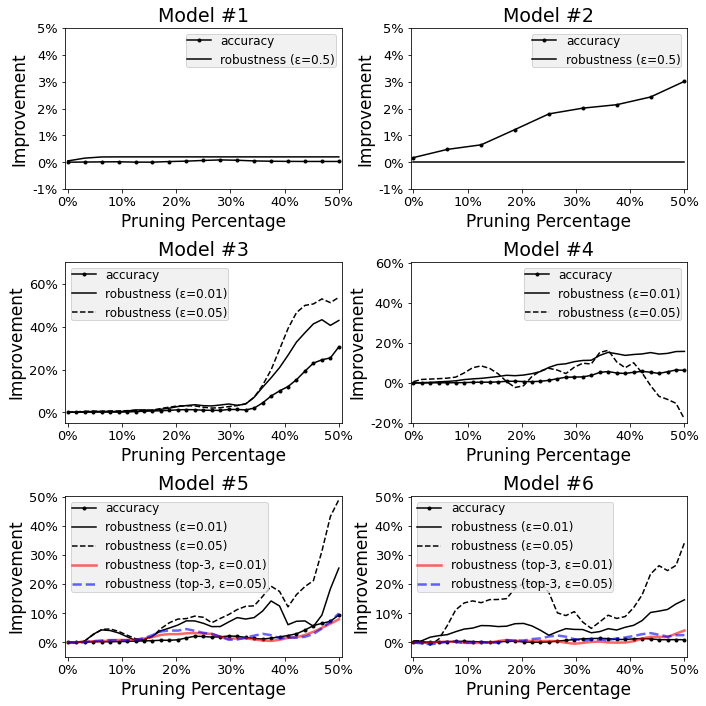

In [154]:

# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

# Create a white layout
gridsize = (3, 2)
fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (0, 1), colspan=1, rowspan=1)
ax3 = plt.subplot2grid(gridsize, (1, 0), colspan=1, rowspan=1)
ax4 = plt.subplot2grid(gridsize, (1, 1), colspan=1, rowspan=1)
ax5 = plt.subplot2grid(gridsize, (2, 0), colspan=1, rowspan=1)
ax6 = plt.subplot2grid(gridsize, (2, 1), colspan=1, rowspan=1)

plot_improvement(0, ax1, ax1)
plot_improvement(1, ax2, ax2)
plot_improvement(2, ax3, ax3)
plot_improvement(3, ax4, ax4)
plot_improvement(4, ax5, ax5)
plot_improvement(5, ax6, ax6)

ax1.title.set_text('Model #1')
ax2.title.set_text('Model #2')
ax3.title.set_text('Model #3')
ax4.title.set_text('Model #4')
ax5.title.set_text('Model #5')
ax6.title.set_text('Model #6')


ax1.set_ylim([-0.01, 0.05])
ax2.set_ylim([-0.01, 0.05])
ax3.set_ylim([-0.05, 0.705])
ax4.set_ylim([-0.2, 0.605])
ax5.set_ylim([-0.05, 0.505])
ax6.set_ylim([-0.05, 0.505])

for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
  ax.set_xlabel('Pruning Percentage')
  ax.set_ylabel('Improvement')      
  # fixing yticks with matplotlib.ticker "FixedLocator"
  ax.xaxis.set_major_formatter(mtick.PercentFormatter())
  ax.set_xticklabels(['{:,.0%}'.format(val) for val in ax.get_xticks()])
  ax.yaxis.set_major_formatter(mtick.PercentFormatter())
  ax.set_yticklabels(['{:,.0%}'.format(val) for val in ax.get_yticks()])
  ax.set_xlim([-0.005, 0.505])
  legend=ax.legend(prop={"size":12}, borderpad=0.05)
  legend.get_frame().set_facecolor('#EEEEEE')

plt.tight_layout()
fig.subplots_adjust(hspace=0.45, wspace=0.25)

figure_filename = "save_figs/improvement_mutiple_plots.pdf"
if os.path.exists(figure_filename):
  os.remove(figure_filename)

plt.savefig(figure_filename)

plt.show()
